In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet


In [2]:
df = pd.read_csv("AirPassengers.csv")
df.columns = ["Month","Passengers"]
df['Month'] = pd.to_datetime(df['Month'])
print(df)

         Month  Passengers
0   1949-01-01         112
1   1949-02-01         118
2   1949-03-01         132
3   1949-04-01         129
4   1949-05-01         121
..         ...         ...
139 1960-08-01         606
140 1960-09-01         508
141 1960-10-01         461
142 1960-11-01         390
143 1960-12-01         432

[144 rows x 2 columns]


In [3]:
print(df.isnull().sum())

Month         0
Passengers    0
dtype: int64


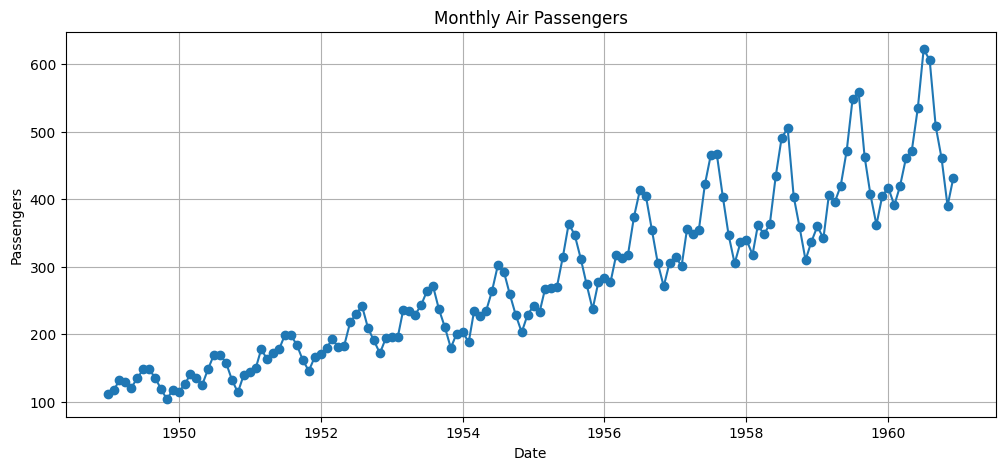

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(df['Month'], df['Passengers'], marker='o')
plt.title('Monthly Air Passengers')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()


In [5]:
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


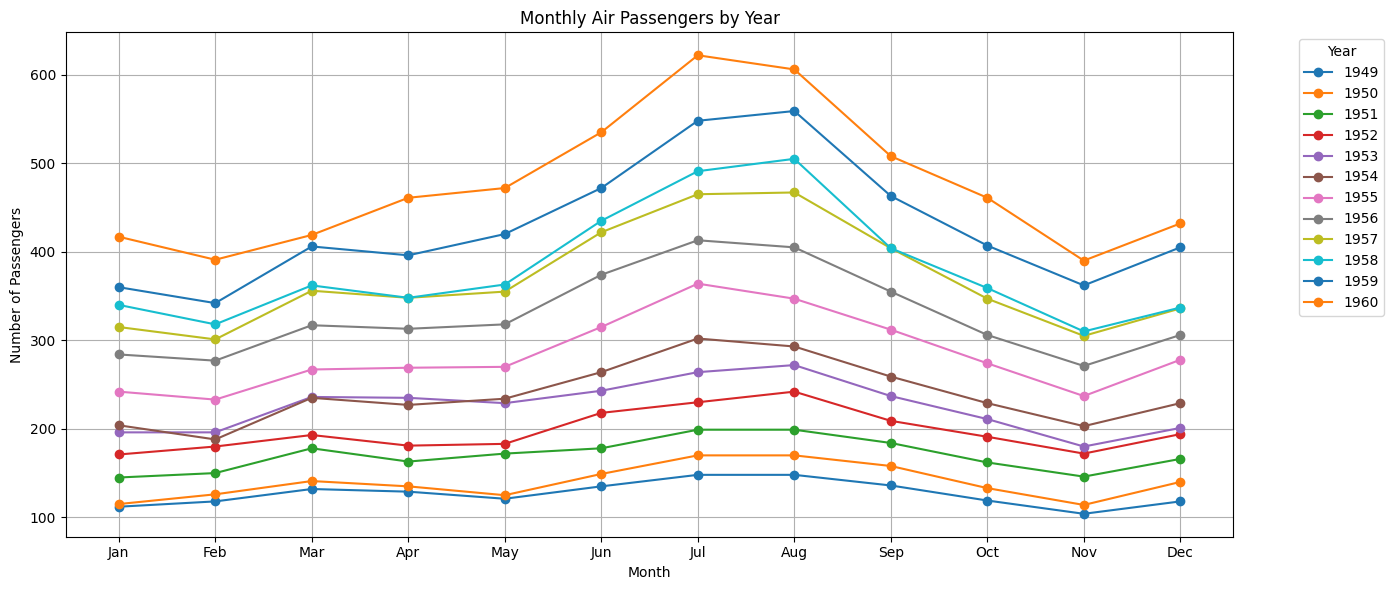

In [6]:
df1 = df.copy()

df1['Month'] = pd.to_datetime(df1['Month'])
df1['Year'] = df1['Month'].dt.year
df1['Month_Num'] = df1['Month'].dt.month

pivot_df = df1.pivot_table(values = 'Passengers', index = 'Month_Num', columns = 'Year')

plt.figure(figsize=(14, 6))

for year in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[year], marker='o', label=str(year))

# 3. Formatting
plt.title('Monthly Air Passengers by Year')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Variation in passengers across months over the years.

c:\Users\Simran Bawaskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


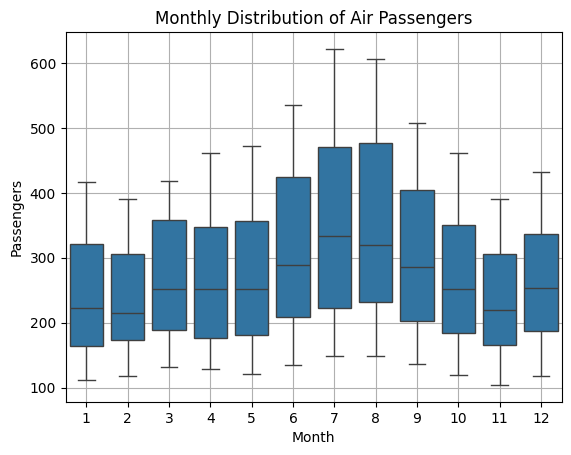

In [7]:
import seaborn as sns

sns.boxplot(x='Month_Num', y='Passengers', data=df1)
plt.title('Monthly Distribution of Air Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

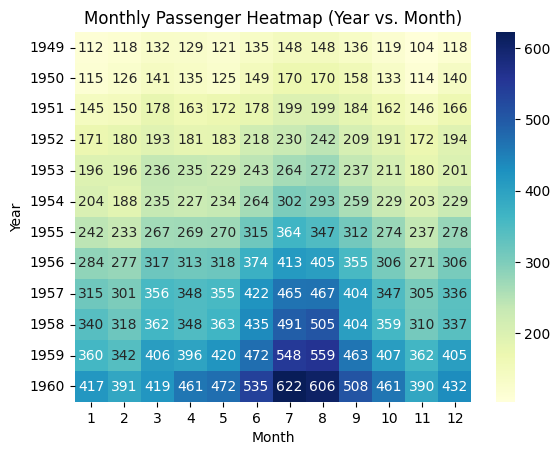

In [8]:
pivot = df1.pivot_table(values='Passengers', index='Year', columns='Month_Num')
sns.heatmap(pivot, annot=True, fmt=".0f", cmap='YlGnBu')
plt.title('Monthly Passenger Heatmap (Year vs. Month)')
plt.xlabel('Month')
plt.ylabel('Year')
plt.show()

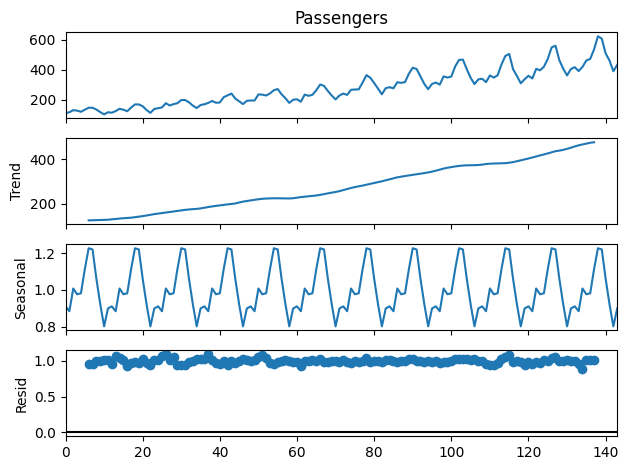

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df1['Passengers'], model='multiplicative', period=12)
decomp.plot()
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    print(f'Used Lag: {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [11]:
adf_test(df['Passengers'])

ADF Statistics: 0.8153688792060463
p- value: 0.991880243437641
Used Lag: 13
Number of Observations Used: 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [12]:
# Differencing
df["Passengers_First_difference"] = df["Passengers"] - df["Passengers"].shift(1)
df.head() 

,Month,Passengers,Passengers_First_difference
0,1949-01-01,112,NaN
1,1949-02-01,118,6.0
2,1949-03-01,132,14.0
3,1949-04-01,129,-3.0
4,1949-05-01,121,-8.0


In [13]:

adf_test(df["Passengers_First_difference"].dropna())

ADF Statistics: -2.8292668241699923
p- value: 0.054213290283826474
Used Lag: 12
Number of Observations Used: 130
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [14]:
df["Passengers_Second_difference"] = df["Passengers"] - df["Passengers"].shift(2)
df.head() 

,Month,Passengers,Passengers_First_difference,Passengers_Second_difference
0,1949-01-01,112,NaN,NaN
1,1949-02-01,118,6.0,NaN
2,1949-03-01,132,14.0,20.0
3,1949-04-01,129,-3.0,11.0
4,1949-05-01,121,-8.0,-11.0


In [15]:
adf_test(df["Passengers_Second_difference"].dropna())

ADF Statistics: -2.961695135555423
p- value: 0.038629757676988535
Used Lag: 11
Number of Observations Used: 130
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


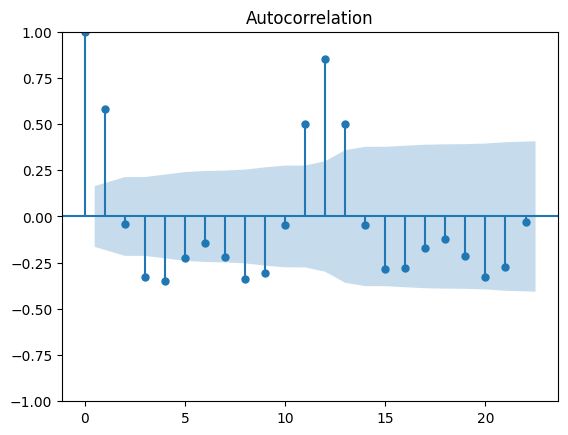

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(df["Passengers_Second_difference"].dropna())

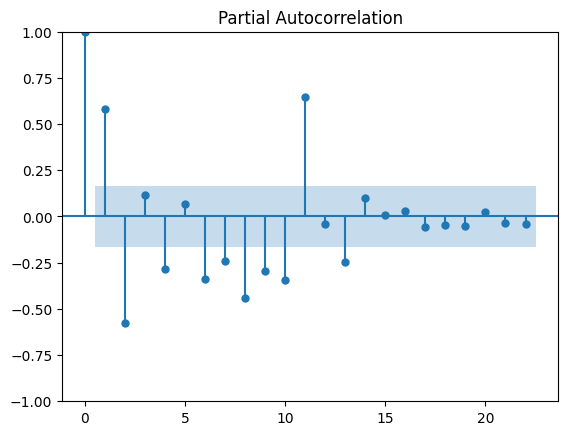

In [17]:
pacf = plot_pacf(df["Passengers_Second_difference"].dropna())

In [18]:
df["Passenger_12_difference"] = df["Passengers"]-df["Passengers"].shift(12)
df.head()

,Month,Passengers,Passengers_First_difference,Passengers_Second_difference,Passenger_12_difference
0,1949-01-01,112,NaN,NaN,NaN
1,1949-02-01,118,6.0,NaN,NaN
2,1949-03-01,132,14.0,20.0,NaN
3,1949-04-01,129,-3.0,11.0,NaN
4,1949-05-01,121,-8.0,-11.0,NaN


In [19]:
adf_test(df["Passenger_12_difference"].dropna())

ADF Statistics: -3.383020726492481
p- value: 0.011551493085514954
Used Lag: 1
Number of Observations Used: 130
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


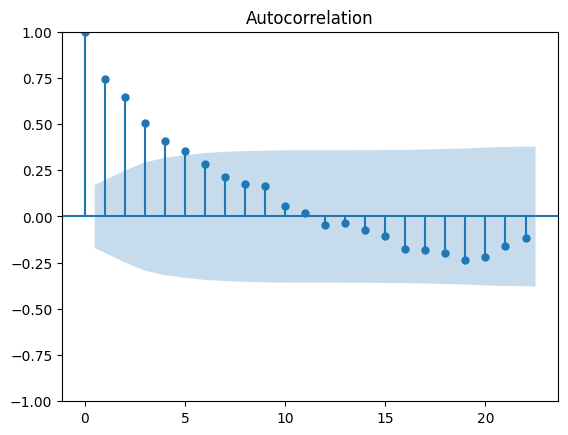

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
acf = plot_acf(df["Passenger_12_difference"].dropna())

ACF Values (q): 2 or 5

PACF Values (p): 2 or 10

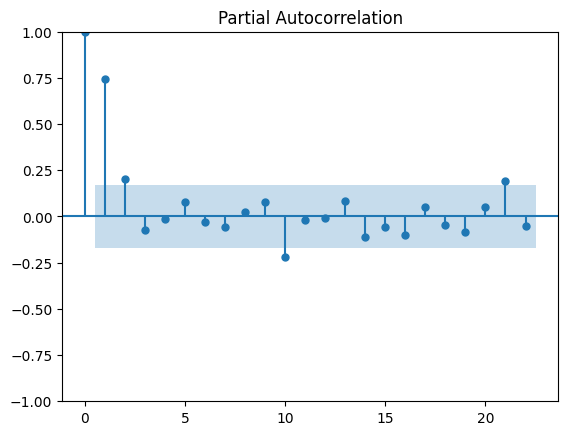

In [21]:
pacf = plot_pacf(df["Passenger_12_difference"].dropna())

In [22]:
df2= df
df2.head()

,Month,Passengers,Passengers_First_difference,Passengers_Second_difference,Passenger_12_difference
0,1949-01-01,112,NaN,NaN,NaN
1,1949-02-01,118,6.0,NaN,NaN
2,1949-03-01,132,14.0,20.0,NaN
3,1949-04-01,129,-3.0,11.0,NaN
4,1949-05-01,121,-8.0,-11.0,NaN


In [23]:
df = df[['Month','Passengers']]
df.head()

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [24]:
# Recreate date index (monthly starting Jan 1949)
df.index = pd.date_range(start='1949-01-01', periods=len(df), freq='MS')
df.index.name = "Month"



In [27]:
from pandas.tseries.offsets import DateOffset
from datetime import datetime
train_dataset_end = datetime(1955, 12, 1)
test_dataset_end = datetime(1960, 12, 1)

train_data = df['Passengers'][:train_dataset_end]
test_data = df['Passengers'][train_dataset_end + DateOffset(months=1):test_dataset_end]

# Define prediction range
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_data,
                order=(2,0,4),  # replace with your (p,d,q)
                seasonal_order=(0,1,1, 12),  # replace with your (P,D,Q,s)
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()


c:\Users\Simran Bawaskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
forecast = results.get_prediction(start=pred_start_date, end=pred_end_date)
forecast_mean = forecast.predicted_mean


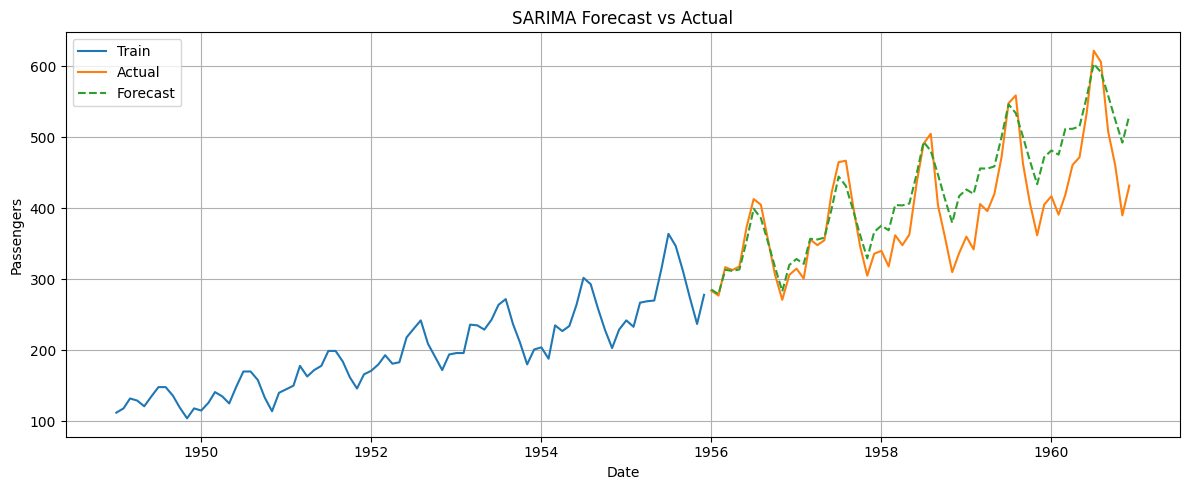

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train_data, label="Train")
plt.plot(test_data, label="Actual")
plt.plot(forecast_mean, label="Forecast", linestyle="--")
plt.title("SARIMA Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Replace (p, d, q) with values you got from ACF/PACF
model_arima = ARIMA(train_data, order=(2,0,4))

results_arima = model_arima.fit()


c:\Users\Simran Bawaskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Simran Bawaskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [32]:
forecast_arima = results_arima.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')


c:\Users\Simran Bawaskar\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


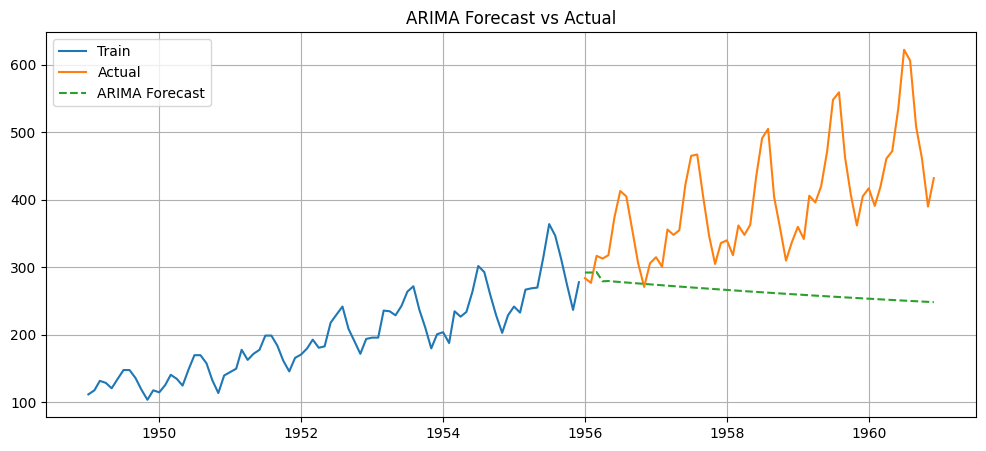

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(train_data, label="Train")
plt.plot(test_data, label="Actual")
plt.plot(forecast_arima, label="ARIMA Forecast", linestyle="--")
plt.legend()
plt.grid(True)
plt.title("ARIMA Forecast vs Actual")
plt.show()


In [34]:
from prophet import Prophet

In [35]:
df_prophet = df.rename(columns={"Month": "ds", "Passengers": "y"})
df_prophet.reset_index(drop = True, inplace= True)
df_prophet.head()

,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [36]:
model = Prophet()

In [37]:
model.fit(df_prophet)

19:11:44 - cmdstanpy - INFO - Chain [1] start processing
19:11:44 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
future = model.make_future_dataframe(periods=len(test_data), freq='MS')  # MS = Month Start
forecast = model.predict(future)


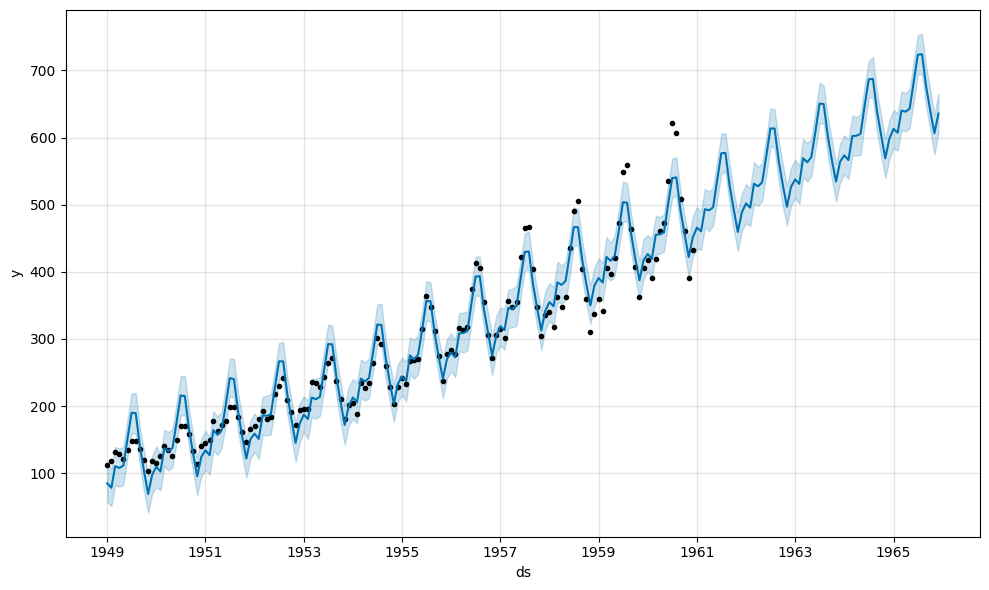

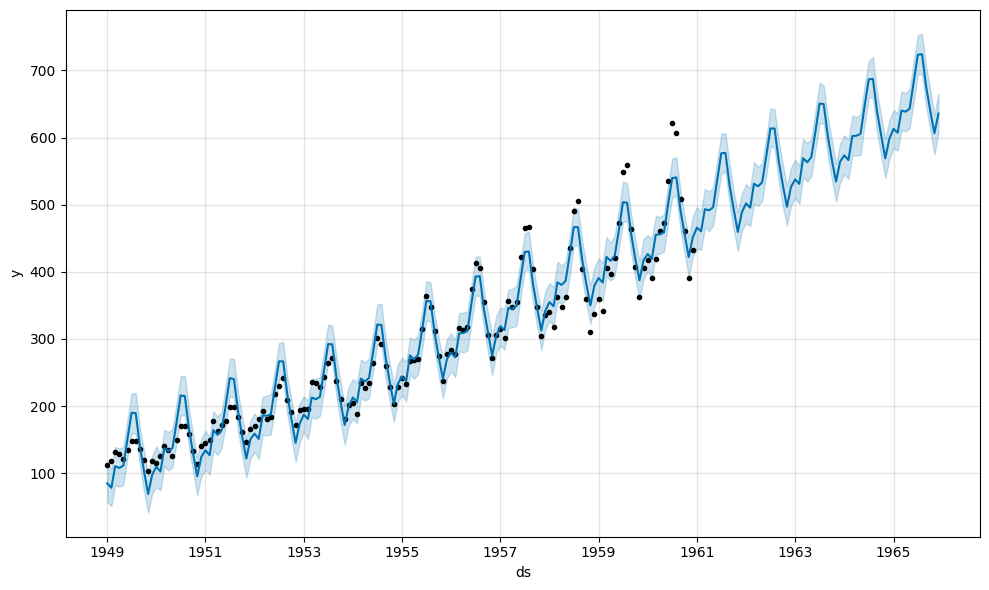

In [39]:
model.plot(forecast)

In [40]:
forecast = forecast.reset_index()
test_data = test_data.reset_index()
forecast.rename(columns={'your_datetime_column': 'ds'}, inplace=True)
test_data.rename(columns={'your_datetime_column': 'ds'}, inplace=True)


In [41]:
print(forecast.columns)
print(test_data.columns)

Index(['index', 'ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower',
       'trend_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Index(['Month', 'Passengers'], dtype='object')


In [42]:
# Step 1: Make sure 'Month' is datetime
test_data['Month'] = pd.to_datetime(test_data['Month'])

# Step 2: Rename columns to match Prophet expectations
test_data = test_data.rename(columns={'Month': 'ds', 'Passengers': 'y'})

# Step 3: Align indexes
forecast_filtered = forecast.set_index('ds').loc[
    test_data['ds'].min():test_data['ds'].max()
]

# Step 4: Merge forecast and actuals
comparison_df = test_data.copy()
comparison_df.set_index('ds', inplace=True)
comparison_df['Forecast'] = forecast_filtered['yhat'].values


In [43]:
forecast_filtered = forecast.set_index('ds').loc[test_data['ds'].min():test_data['ds'].max()]
comparison_df = test_data.copy()
comparison_df.set_index('ds', inplace=True)
comparison_df['Forecast'] = forecast_filtered['yhat'].values


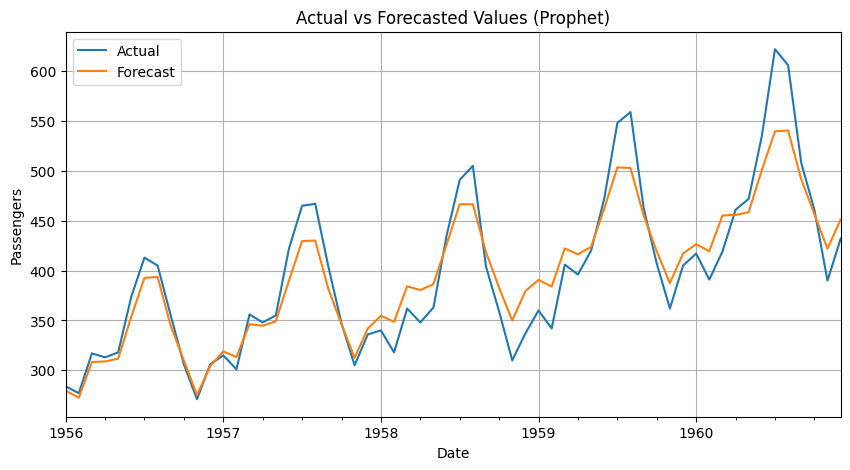

In [44]:
import matplotlib.pyplot as plt

comparison_df[['y', 'Forecast']].plot(figsize=(10, 5))
plt.title("Actual vs Forecasted Values (Prophet)")
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.legend(["Actual", "Forecast"])
plt.grid(True)
plt.show()


In [45]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison_df['y'], comparison_df['Forecast'])
rmse = np.sqrt(mean_squared_error(comparison_df['y'], comparison_df['Forecast']))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE: 20.33
RMSE: 26.25


In [46]:
sarima_forecast = results.get_prediction(start=pred_start_date, end=pred_end_date)
sarima_forecast_mean = sarima_forecast.predicted_mean


In [47]:
forecast_filtered = forecast.set_index('ds').loc[test_data['ds'].min():test_data['ds'].max()]
prophet_forecast = forecast_filtered['yhat']


In [48]:
prophet_forecast = prophet_forecast.reindex(test_data['ds'].values)


In [49]:
# Set correct index
test_data.set_index('ds', inplace=True)

comparison_df = pd.DataFrame({
    'Actual': test_data['y'].values,
    'SARIMA': sarima_forecast_mean.values,
    'Prophet': prophet_forecast.values
}, index=test_data.index)


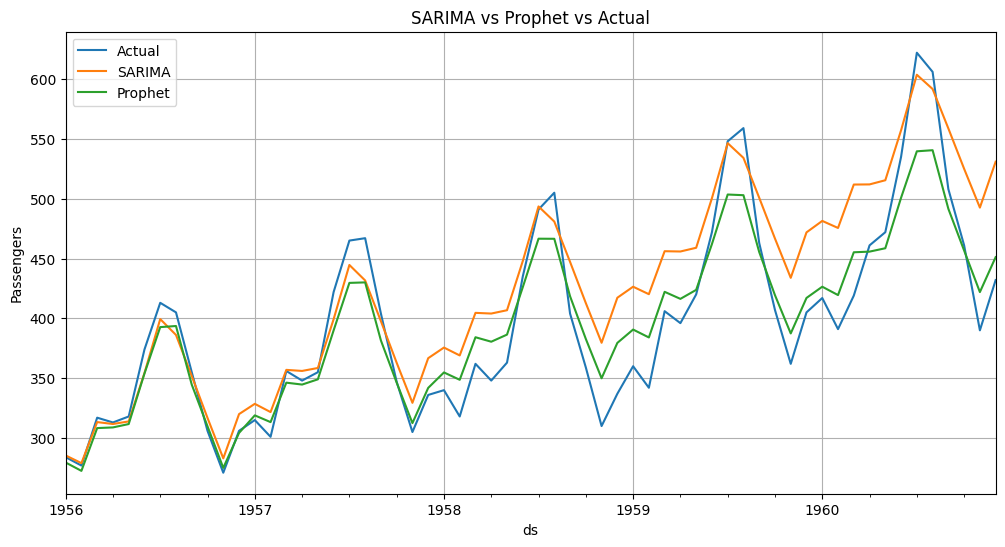

SARIMA  → RMSE: 44.77, MAE: 35.24
Prophet → RMSE: 26.25, MAE: 20.33


In [50]:
# Plot
comparison_df.plot(figsize=(12, 6))
plt.title("SARIMA vs Prophet vs Actual")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse_sarima = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['SARIMA']))
rmse_prophet = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['Prophet']))

mae_sarima = mean_absolute_error(comparison_df['Actual'], comparison_df['SARIMA'])
mae_prophet = mean_absolute_error(comparison_df['Actual'], comparison_df['Prophet'])

print(f"SARIMA  → RMSE: {rmse_sarima:.2f}, MAE: {mae_sarima:.2f}")
print(f"Prophet → RMSE: {rmse_prophet:.2f}, MAE: {mae_prophet:.2f}")
